In [2]:
import mne
import yasa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ipywidgets as widgets

%matplotlib qt

In [3]:
fname = '/Users/idohaber/Desktop/101_test_data/Strength_101_N1_forSW.set'
raw = mne.io.read_raw_eeglab(fname,preload=True)
raw.resample = 100
data = raw.get_data(units="uV")

Reading /Users/idohaber/Desktop/101_test_data/Strength_101_N1_forSW.fdt
Reading 0 ... 9297824  =      0.000 ... 18595.648 secs...


In [4]:

channel = raw.info['ch_names']
sf = raw.info['sfreq']
print(data.shape, sf, channel)

(198, 9297825) 500.0 ['E2', 'E3', 'E4', 'E5', 'E6', 'E7', 'E8', 'E9', 'E11', 'E14', 'E15', 'E16', 'E17', 'E18', 'E22', 'E23', 'E24', 'E25', 'E27', 'E29', 'E30', 'E31', 'E32', 'E36', 'E37', 'E40', 'E41', 'E42', 'E43', 'E44', 'E45', 'E46', 'E47', 'E48', 'E49', 'E50', 'E51', 'E52', 'E53', 'E54', 'E55', 'E56', 'E57', 'E60', 'E61', 'E62', 'E68', 'E73', 'E76', 'E77', 'E78', 'E79', 'E80', 'E81', 'E82', 'E85', 'E86', 'E87', 'E88', 'E89', 'E91', 'E92', 'E93', 'E98', 'E99', 'E100', 'E101', 'E102', 'E103', 'E109', 'E110', 'E111', 'E112', 'E113', 'E114', 'E117', 'E118', 'E119', 'E120', 'E121', 'E122', 'E123', 'E124', 'E125', 'E126', 'E127', 'E128', 'E129', 'E130', 'E131', 'E132', 'E133', 'E134', 'E135', 'E136', 'E137', 'E138', 'E139', 'E140', 'E141', 'E142', 'E143', 'E144', 'E145', 'E146', 'E147', 'E148', 'E149', 'E150', 'E151', 'E152', 'E153', 'E154', 'E155', 'E156', 'E157', 'E158', 'E159', 'E162', 'E163', 'E165', 'E166', 'E167', 'E168', 'E171', 'E172', 'E174', 'E175', 'E176', 'E177', 'E178', 'E1

In [5]:
fig_2d = raw.plot_sensors(kind='topomap', show_names=True, show=False)

In [6]:
events = mne.events_from_annotations(raw)  # raw events
events_id = events[-1]                     # grab event dict
actual_events = events[:-1][0]             # grab actual events
print(events_id, '\n') 
print(actual_events)

Used Annotations descriptions: ['stim end', 'stim start']
{'stim end': 1, 'stim start': 2} 

[[ 285418       0       2]
 [ 393453       0       1]
 [ 650362       0       2]
 [ 753307       0       1]
 [1008385       0       2]
 [1116421       0       1]
 [1364397       0       2]
 [1472438       0       1]
 [1718560       0       2]
 [1823876       0       1]
 [2007282       0       2]
 [2096473       0       1]
 [2391095       0       2]
 [2498220       0       1]
 [2774414       0       2]
 [2882458       0       1]
 [3302843       0       2]
 [3410881       0       1]
 [3717432       0       2]
 [3810466       0       1]]


In [7]:
# Extract events and event IDs from annotations in the raw data
events, event_id = mne.events_from_annotations(raw)

print(event_id, '\n')
print(events)

# Dictionary mapping event descriptions to numerical codes
column_dict = {'stim end': 1, 'stim start': 2}

# Indices for 'stim end' and 'stim start'
stim_end_index = column_dict['stim end']
stim_start_index = column_dict['stim start']

# Filter events to get only stim start and stim end
filtered_data = [item for item in events if item[2] == stim_end_index or item[2] == stim_start_index]

# Minimum stim duration threshold in seconds (example: 100 seconds)
min_stim_duration_sec = 100
min_stim_duration_samples = int(min_stim_duration_sec * sf)

# Initialize lists for pre-stim, early stim, late stim, and post-stim epochs with protocol numbers
pre_stim_epochs = []
early_stim_epochs = []
late_stim_epochs = []
post_stim_epochs = []

# Previous epoch end to check for overlap
previous_end = 0

# Protocol counter
protocol_number = 1

# Loop through the epochs and define pre-stim, early stim, late stim, and post-stim epochs
for i in range(0, len(filtered_data), 2):
    if i + 1 < len(filtered_data):  # Ensure i+1 is within bounds
        stim_start = filtered_data[i][0]
        stim_end = filtered_data[i+1][0]
        stim_duration = stim_end - stim_start  # Calculate stim duration
        
        if stim_duration < min_stim_duration_samples:
            continue  # Skip this stim epoch if it is shorter than the minimum duration
        
        stim_midpoint = (stim_start + stim_end) // 2  # Calculate the midpoint of the stim epoch
        
        pre_stim_epoch = (stim_start - stim_duration, stim_start, protocol_number)
        early_stim_epoch = (stim_start, stim_midpoint, protocol_number)
        late_stim_epoch = (stim_midpoint, stim_end, protocol_number)
        post_stim_epoch = (stim_end, stim_end + stim_duration, protocol_number)
        
        # Check for overlap with the previous epoch
        if pre_stim_epoch[0] < previous_end:
            continue  # Skip this entire protocol if there's an overlap with the previous one
        
        # Update previous_end to the end of the current post-stim epoch
        previous_end = post_stim_epoch[1]
        
        pre_stim_epochs.append(pre_stim_epoch)
        early_stim_epochs.append(early_stim_epoch)
        late_stim_epochs.append(late_stim_epoch)
        post_stim_epochs.append(post_stim_epoch)
        
        # Increment protocol number
        protocol_number += 1

# Convert epochs to time for plotting
def convert_sample_to_time(epochs, sf):
    return [(start / sf, end / sf) for start, end, protocol in epochs]

pre_stim_epochs_time = convert_sample_to_time(pre_stim_epochs, sf)
early_stim_epochs_time = convert_sample_to_time(early_stim_epochs, sf)
late_stim_epochs_time = convert_sample_to_time(late_stim_epochs, sf)
post_stim_epochs_time = convert_sample_to_time(post_stim_epochs, sf)

# Optionally store or print protocol numbers for reference
protocol_numbers = [epoch[2] for epoch in pre_stim_epochs]  # Collect protocol numbers (only need to do it once)
print(f"Protocol Numbers: {protocol_numbers}")

# Plotting
plt.figure(figsize=(10, 6))

# Plot pre-stim epochs as shaded regions
for (start, end) in pre_stim_epochs_time:
    plt.axvspan(start, end, color='blue', alpha=0.3, label='Pre-Stim')

# Plot early stim epochs as shaded regions and add protocol numbers
for i, (start, end) in enumerate(early_stim_epochs_time):
    plt.axvspan(start, end, color='orange', alpha=0.3, label='Early Stim')
    # Add the protocol number only for early stim, to represent the entire protocol
    plt.text((start + end) / 2, 0.2, f'P{protocol_numbers[i]}', color='black', fontsize=10, ha='center')

# Plot late stim epochs as shaded regions
for (start, end) in late_stim_epochs_time:
    plt.axvspan(start, end, color='red', alpha=0.3, label='Late Stim')

# Plot post-stim epochs as shaded regions
for (start, end) in post_stim_epochs_time:
    plt.axvspan(start, end, color='green', alpha=0.3, label='Post-Stim')

# Set labels and title
plt.xlabel('Time (s)')
plt.ylabel('Epoch Type')
plt.title('Stimulation Protocols Visualization')

# To prevent duplicate labels in the legend
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

plt.show()

Used Annotations descriptions: ['stim end', 'stim start']
{'stim end': 1, 'stim start': 2} 

[[ 285418       0       2]
 [ 393453       0       1]
 [ 650362       0       2]
 [ 753307       0       1]
 [1008385       0       2]
 [1116421       0       1]
 [1364397       0       2]
 [1472438       0       1]
 [1718560       0       2]
 [1823876       0       1]
 [2007282       0       2]
 [2096473       0       1]
 [2391095       0       2]
 [2498220       0       1]
 [2774414       0       2]
 [2882458       0       1]
 [3302843       0       2]
 [3410881       0       1]
 [3717432       0       2]
 [3810466       0       1]]
Protocol Numbers: [1, 2, 3, 4, 5, 6, 7, 8, 9]


In [25]:
channel_index = 0  # Change this to the index of the channel you want to use
single_channel_data = data[channel_index, :]

# Specify the corresponding channel name
channel_name = [channel[channel_index]]  # Make sure this corresponds to the selected channel

# Run spindle detection on the selected channel
sp = yasa.spindles_detect(single_channel_data, sf, ch_names=channel_name, multi_only=False)

In [28]:
df = sp.summary(); # general summary for each sw
df # Inspect the dataframe

,Start,Peak,End,Duration,Amplitude,RMS,AbsPower,RelPower,Frequency,Oscillations,Symmetry,Channel,IdxChannel
0,192.330,192.722,193.304,0.974,100.102924,25.268928,2.800473,0.420769,13.226295,12.0,0.401639,E14,0
1,228.884,229.144,229.422,0.538,49.071216,9.807276,2.146416,0.377389,13.558801,7.0,0.481481,E14,0
2,264.052,264.444,264.726,0.674,39.653975,9.210965,2.090953,0.514504,13.672186,9.0,0.579882,E14,0
3,303.586,303.848,304.154,0.568,72.219284,16.078897,2.516837,0.458565,13.611743,8.0,0.459649,E14,0
4,342.346,342.668,342.916,0.570,67.902495,14.874025,2.269933,0.240242,12.772581,7.0,0.562937,E14,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
616,17981.110,17981.758,17981.962,0.852,45.441741,9.208046,1.852807,0.372446,12.869890,11.0,0.758782,E14,0
617,18372.812,18373.048,18373.514,0.702,39.322076,9.205734,1.910135,0.371893,12.911004,8.0,0.335227,E14,0
618,18517.844,18518.328,18518.516,0.672,72.059785,16.397504,2.368294,0.271505,12.280552,8.0,0.718101,E14,0
619,18550.576,18550.756,18551.732,1.156,75.641528,12.311557,2.000752,0.390882,13.866363,14.0,0.155440,E14,0


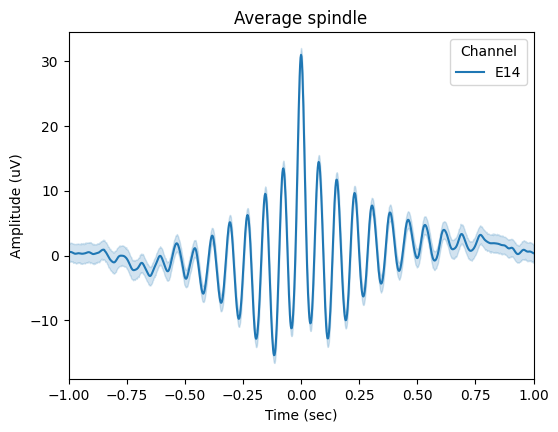

In [26]:
%matplotlib inline
sp.plot_average(center='Peak', time_before=1, time_after=1);

In [29]:
# Define the classification function
def classify_wave(start_time, pre_stim_epochs_time, early_stim_epochs_time, late_stim_epochs_time, post_stim_epochs_time):
    """Classify each wave based on the start time into 'Pre-Stim', 'Early-Stim', 'Late-Stim', or 'Post-Stim' and assign protocol number."""
    for idx, (start, end) in enumerate(pre_stim_epochs_time):
        if start <= start_time <= end:
            return 'Pre-Stim', idx + 1
    for idx, (start, end) in enumerate(early_stim_epochs_time):
        if start <= start_time <= end:
            return 'Early-Stim', idx + 1
    for idx, (start, end) in enumerate(late_stim_epochs_time):
        if start <= start_time <= end:
            return 'Late-Stim', idx + 1
        
    for idx, (start, end) in enumerate(post_stim_epochs_time):
        if start <= start_time <= end:
            return 'Post-Stim', idx + 1
    return 'Unknown', None  # If the wave does not fall within any of the epochs

# Apply classification to DataFrame
df[['Classification', 'Protocol Number']] = df['Start'].apply(lambda start_time: classify_wave(start_time, pre_stim_epochs_time, early_stim_epochs_time, late_stim_epochs_time, post_stim_epochs_time)).apply(pd.Series)

# Filter out rows classified as 'Unknown'
df_filtered = df[df['Classification'] != 'Unknown']

# Now df_filtered contains both the classification and the protocol number for each wave.

In [32]:
# Group by classification and calculate mean and count for each group
comparison_means = df_filtered.groupby('Classification')[['Duration', 'Amplitude', 'Oscillations']].mean()
comparison_counts = df_filtered.groupby('Classification')['Start'].count()  # Counting instances using the 'Start' column

# Print results
print("Mean Values by Group:")
print(comparison_means)
print("\nCount of Instances by Group:")
print(comparison_counts)

Mean Values by Group:
                Duration  Amplitude  Oscillations
Classification                                   
Early-Stim      0.932154  70.316515     11.653846
Late-Stim       0.746222  70.274763      9.500000
Post-Stim       0.840074  75.408227     10.814815
Pre-Stim        0.824741  71.138711     10.648148

Count of Instances by Group:
Classification
Early-Stim    26
Late-Stim     18
Post-Stim     27
Pre-Stim      54
Name: Start, dtype: int64
